# Figure overview

## One figure that does a quick run-through of the most important plots from the 10 week figures (i.e. all previous figures) 

1. Figure 1
    - Show RBG over time
    - Show OGTTs
2. Figure 2
    - Show PCA that will likely separate Male vs female
3. Figure 3
    - Bar plot of each animal's non-fasted RSDs for all lipids
    - Maybe do heatmap plot for each lipid class? 
4. Figure 4 - Machine learning model comparison and feature importance
    - OGTT isn't very wide range here, so skip
5. Figure 5 - Individual metabolite regressions 
    - Slope vs slope
    - TG unsat vs carbons
6. 

In [897]:
import json
import importlib
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots
from src.plots import plot_quant_vs_ogtt, annotate_point
import importlib

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib import patches, transforms
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns 
import plotly.express as px
import networkx as nx
import statsmodels.api as sm
import statsmodels 

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [570]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

vldata = pd.read_csv('../data/processed/1700s_validation_lipids.csv', index_col=0)
vldata_cols = fg.loc[(fg['cohort'] == '30wk') & fg['has_ogtt']].index
qc_rep_1700s = fg.loc[fg['qc_rep']].index

In [33]:
animals = ap.loc[ap['validation'] & (ap['OGTT_age'].notna()) & (ap['cohort'] == '30wk')].index
animals

df = ap.filter(regex='^RBGweek').iloc[:, 6:].loc[animals]
df.columns = [int(x[-2:]) for x in df.columns]
df

new = []
for animal in animals:
    row = df.loc[animal]
    age = ap.loc[animal, 'OGTT_age']
#     print(age)
    weeks_b4_ogtt = [idx - age for idx in row.index]
    row.index = weeks_b4_ogtt
#     display(row)
    new.append(row)
wkdf = pd.DataFrame(new).iloc[:, 1:-3]
wkdf['animal'] = wkdf.index
# wkdf = wkdf.join(ap['sex'])
wkdf
wkdf = wkdf.melt(id_vars='animal', value_vars=wkdf.columns[:-1], 
                 var_name='week', value_name='rbg')
wkdf = wkdf.join(ap['sex'], on='animal' )
wkdf = wkdf.loc[wkdf['week'] > -7 ]
wkdf

,animal,week,rbg,sex
99,1727,-6.0,229.0,M
100,1728,-6.0,241.0,M
101,1731,-6.0,82.0,F
102,1732,-6.0,90.0,M
103,1735,-6.0,83.0,M
...,...,...,...,...
171,1746,0.0,116.0,F
172,1748,0.0,246.5,F
173,1742,0.0,NaN,F
174,1743,0.0,NaN,F


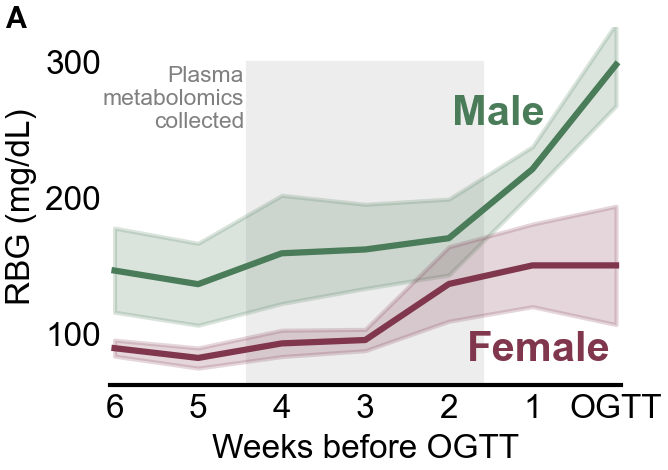

In [904]:
importlib.reload(src.plots)
fig, ax = plt.subplots(dpi=300, figsize=(2.2, 1.55))
sns.lineplot(
    data=wkdf, x='week', y='rbg', ax=ax,
    hue='sex', palette=colors, 
    ci=68, n_boot=200, seed=1,
    legend=False,
)
ax.axvspan(-4.4, -1.6,  ymax=0.9, color='0.93', zorder=-10)
ax.text(-4.45, 297, 'Plasma\nmetabolomics\ncollected', color='0.5', fontsize=5.5, 
        ha='right', va='top')
# ax.text(-4.4, 300, 'Plasma metabolomics\ncollected', ha='left', va='top', 
#         fontsize=5, color='0.5')

ax.set_ylabel(None)

ax.set_xlabel('Weeks before OGTT', fontsize=8)
ax.tick_params(pad=2, length=0, labelsize=8)
# ax.set_xticks(np.arange(-10, 2, 2), labels=[str(x) for x in np.arange(10,0,-2)] + ['OGTT'])
ax.set_xticks([-6, -5, -4, -3, -2, -1, 0], ['6', '5', '4', '3', '2', '1', 'OGTT'])

# ax.text(0.0, 0.88, 'RBG (mg/dL)', fontsize=8, transform=ax.transAxes)
# ax.set_title('RBG (mg/dL)', fontsize=8, loc='left')
ax.set_ylabel('RBG (mg/dL)')
ax.set_ylim(top=325)
ax.set_yticks([100, 200, 300])
ax.text(0.85, 0.73, r'Male', color=colors['M'], fontweight='bold', fontsize=10, 
        ha='right', transform=ax.transAxes)
ax.text(0.98, 0.07, 'Female', color=colors['F'], fontweight='bold', fontsize=10, 
        ha='right', transform=ax.transAxes)
ax.set_axisbelow(True)
# ax.grid(axis='y', lw=src.plots.GRID_LW, ls='-', color=src.plots.GRID_LIGHT_COLOR)
ax.spines['bottom'].set_linewidth(1)
ax.set_xmargin(0.01)
bb = src.plots.tight_bbox(ax)
ax.text(x=bb.x0, y=bb.y1, s='A', 
        fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )
sns.despine(left=True)

plt.savefig('../reports/figures/Figure7/Fig7A_RBGs_before_OGTT.pdf', bbox_inches='tight')

# Repeated measures variance of the 30 week data

# Caveat: these data are skeptical because instrument variance might have been lower with this batch 
## Also, the same features are not being compared, though this may not be bad because different age groups can have different metabolite abundances 

In [804]:
gb = np.power(2, vldata.loc[:, vldata_cols])
gb = (gb
      .T
#       .join(fg[['animal', 'sex']])
      .groupby(fg['animal'])
     )
gb = (gb.std() / gb.mean()) * 100
gb['median'] = gb.median(axis=1)
gb.index = gb.index.astype(int)
gb = gb.join(ap[['sex', 'OGTT (AUC)']])
gb['animal'] = gb.index
sdf = gb.groupby('sex').mean()['median']
gb

melt = gb.drop(['OGTT (AUC)', 'median'], axis=1).melt(id_vars=['animal', 'sex'])
order = ap.loc[gb.index, ['Nile rat label', 'sex', 'OGTT (AUC)']].sort_values('Nile rat label')
order['ogtt'] = order['OGTT (AUC)'].round(-3).astype('str').str[:2] + 'k'
order['label'] = order['Nile rat label'] + '\n[' + order['ogtt'] + ']'
order['median'] = gb.median(axis=1)
order = order.sort_values(['sex', 'median'])
order['x'] = range(len(order))
order

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,Nile rat label,sex,OGTT (AUC),ogtt,label,median,x
animal,,,,,,,
1743,N,F,35757.5,36k,N\n[36k],13.168419,0
1754,M,F,31460.0,31k,M\n[31k],14.477538,1
1731,S,F,41218.5,41k,S\n[41k],14.873750,2
1748,P,F,37650.0,38k,P\n[38k],16.638058,3
1746,L,F,29785.0,30k,L\n[30k],19.241205,4
1742,K,F,25742.5,26k,K\n[26k],20.798072,5
1732,Q,M,37860.0,38k,Q\n[38k],13.768446,6
1741,U,M,44045.0,44k,U\n[44k],13.871115,7
1735,O,M,36090.0,36k,O\n[36k],18.738975,8


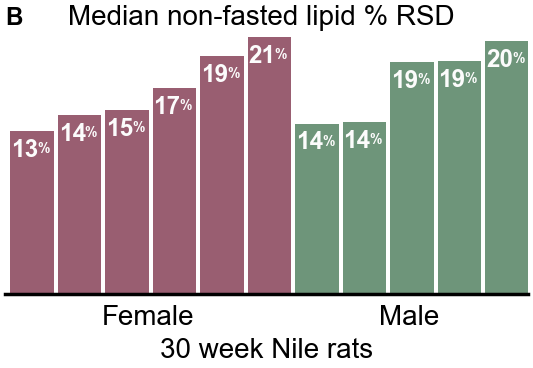

In [899]:
fig, ax = plt.subplots(dpi=250, figsize=(2.7, 1.4))
sns.barplot(
    data=melt, x='animal', y='value', hue='sex', palette=colors, hue_order=['F', 'M'],
    dodge=False,
    estimator=np.median, seed=1, n_boot=100,
    order=order.index,
    ci=None,
#     errwidth=1., capsize=0.4,  errcolor='0.05', 
    alpha=0.8, saturation=0.99,
)
for child in ax.get_children():
    if isinstance(child, plt.Rectangle):
        child.set_width(0.92)

for i, row in order.iterrows():
    med = row['median']
    ax.text(row['x']-0.38, med-1.5, 
            str(round(med, 0))[:-2],  
            color='0.99', fontsize=7, fontweight='bold', 
            ha='left', va='center')
    ax.text(row['x']+0.17, med-1.4, 
            '%', 
            color='0.99', fontsize=4, fontweight='bold', 
            ha='left', va='center')

ax.tick_params(length=0, pad=3, labelsize=8)
ax.set_yticks([])
ax.set_xticks([2.5, 8], ['Female', 'Male'], ha='center')
ax.set_xlabel('30 week Nile rats')#\n[OGTT glucose AUC]')
ax.set_ylabel(None)

ax.text(0.12, 1, 'Median non-fasted lipid % RSD', fontsize=8, 
        transform=ax.transAxes)
h, l = ax.get_legend_handles_labels()
# ax.legend(handles=h, labels=['Female', 'Male',], loc=(1.01, 0.3), 
#           borderpad=0, labelspacing=0.34, frameon=False, handletextpad=0.3, fontsize=8)
ax.legend([])
ax.spines['bottom'].set_linewidth(1)
ax.set_xmargin(0.01)
# ax.grid(axis='y', lw=0.5, ls='-', color='0.8')
# ax.spines['bottom'].set_linewidth(1)
bb = src.plots.tight_bbox(ax)
ax.text(x=bb.x0, y=bb.y1*0.94, s='B', 
        fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure, )

sns.despine(left=True)

plt.savefig('../reports/figures/Figure7/Fig7B_RSD_barplot.pdf', bbox_inches='tight', dpi=300)

## Slope vs slope plot

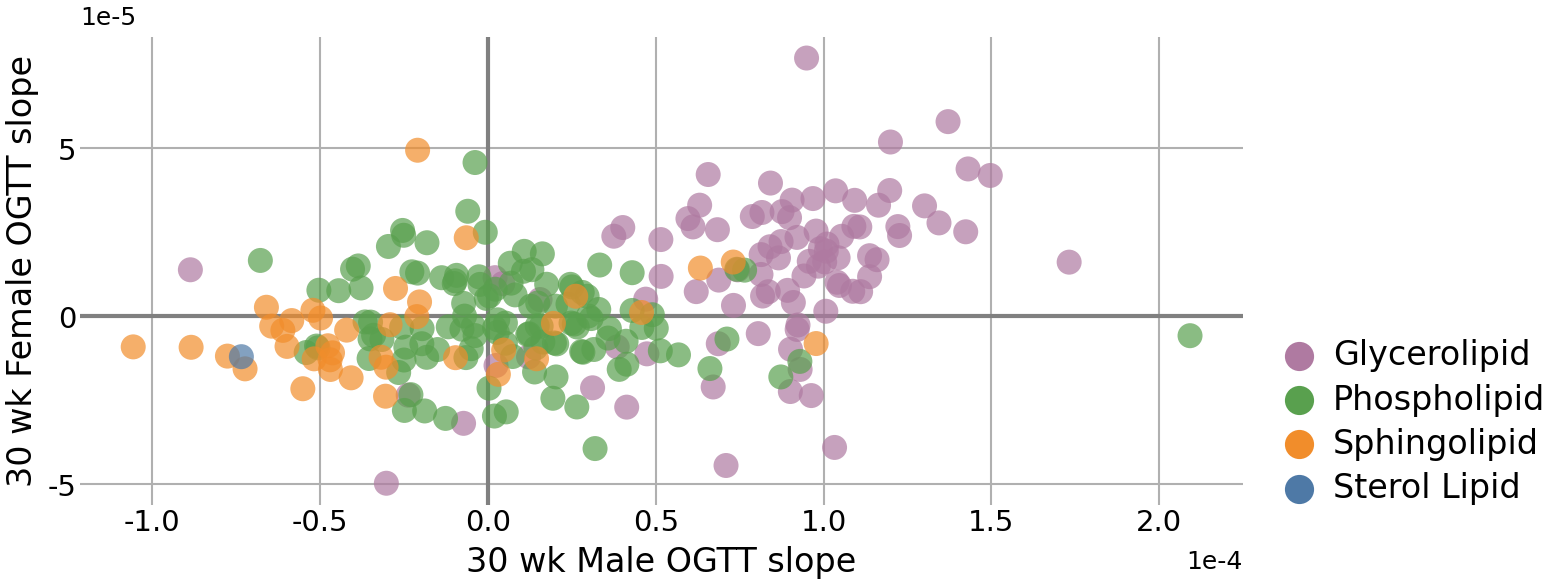

In [97]:
fig, ax = plt.subplots(dpi=300, figsize=(5, 5))
slope_df = vldata.loc[vldata['is_id']]
slope_df = slope_df.sort_values('superclass')
sns.scatterplot(
    data=slope_df, 
    x='coef_male_ogtt', y='coef_female_ogtt', hue='superclass', palette=colors,
    edgecolor='none', alpha=0.7, zorder=10,
)

## Label outliers 
# for i, row in df.iterrows():
#     if row['F_ogtt_slope'] > 0.00005 or row['F_ogtt_slope'] < -0.000038 or \
#         row['M_ogtt_slope'] > 0.00015 or row['M_ogtt_slope'] < -0.00008:
#         ax.text(row['M_ogtt_slope'], row['F_ogtt_slope'], row['ID'], 
#                 fontsize=5, ha='center', va='center')
        
ax.set_xlabel('30 wk Male OGTT slope')
ax.set_ylabel('30 wk Female OGTT slope')
ax.set_xticks([-10e-5, -5e-5, 0, 5e-5, 10e-5, 15e-5, 20e-5])
ax.set_yticks([-5e-5, 0, 5e-5])

ax.axvline(0, color='gray', lw=1, zorder=5)
ax.axhline(0, color='gray', lw=1, zorder=5)
ax.legend(loc=(1.01, 0))
ax.ticklabel_format(style='sci', scilimits=(0, 0), axis='both')
ax.tick_params(length=0, pad=1, labelsize=7)

ax.grid(lw=0.5)
ax.set_axisbelow(True)
ax.set_aspect('equal')
# set_square_ratio(ax)

ax.legend(loc=(1.02, 0), borderpad=0, labelspacing=0.34, frameon=False, handletextpad=0, fontsize=8)

sns.despine(bottom=True, left=True, ax=ax)

# plt.savefig('../reports/figures/Figure6/valdiation_ogtt_slope_vs_slope.pdf', bbox_inches='tight')

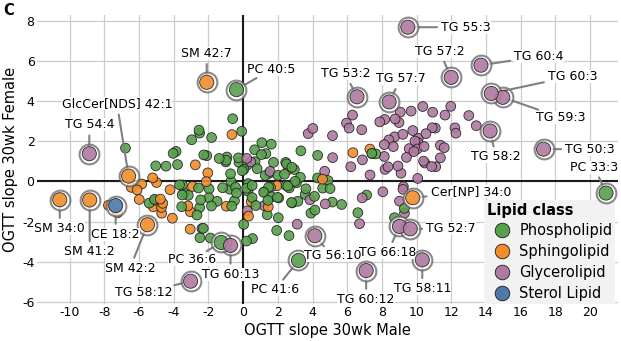

In [435]:
def slope_vs_slope_wrapper(ax=None):
    if ax is None:
        fig, ax = plt.subplots(dpi=150, figsize=(5, 2.5))
    importlib.reload(src.plots)
    vldata['size_dummy'] = 0
    df = vldata
    outliers = {
        'vl_6200': dict(x=10, y=0),  # TG 55:3
        'vl_6379': dict(x=10, y=3),  # TG 60:4
        'vl_5645': dict(x=8, y=0),    # TG 50:3
        'vl_6431': dict(x=10, y=-7),  # TG 18:2 18:1 23:0
        'vl_6458': dict(x=14, y=6),   # TG 18:2 18:1 24:0
        'vl_6461': dict(x=1, y=-9),  # TG 58:2
        'vl_6436': dict(x=-2, y=9),  # TG 57:2
        'vl_6183': dict(x=-2, y=8),  # TG 53:2
        'vl_5748': dict(x=2, y=8),  # TG 57:7

        'vl_2305':  dict(x=-2, y=9),  # PC 33:3
        'vl_5226': dict(x=0, y=-10),  # TG 16:0 20:5 22:6  58:11
        'vl_5124': dict(x=0, y=-10),  # TG 18:2 20:5 22:5
        'vl_2813': dict(x=-4, y=-10),  # PC 41:6
        'vl_3013': dict(x=10, y=2),  # Cer[NP] t18:0 16:0
        'vl_4879': dict(x=-2, y=-9),  # TG 22:6 66:18
        'vl_5174': dict(x=7, y=0),  #  TG 52:7

        'vl_4920': dict(x=-8, y=-4),  # TG 18:2 20:5 20:5  58:12
        'vl_2876': dict(x=0, y=-10),  # SM d34:0
        'vl_4004': dict(x=0, y=-18),  # SM d41:2
        'vl_4133': dict(x=-3, y=-15),  # SM d42:2
        'vl_5883': dict(x=0, y=-10), # CE 18:2
        'vl_5024': dict(x=0, y=-10),  # TG 60:13
    #     'vl_5224': dict(x=-2, y=-10),  # TG 60:12
        'vl_2167': dict(x=-5, y=-6),  #
        'vl_5156': dict(x=3, y=-7),  #  TG 


        'vl_2384': dict(x=0, y=10), # SM d42:7
        'vl_3484': dict(x=6, y=7),  # PC 40:5
        'vl_6022': dict(x=0, y=10),  # TG 16:0 18:0 20:4
        'vl_4657': dict(x=-2, y=25),  # Cer
        }
    df['outlier'] = df.index.isin(outliers)
    src.plots.slope_vs_slope(
        df=vldata, x='coef_male_ogtt', y='coef_female_ogtt', metab_type='lipid', ax=ax,
        size='outlier', alpha=0.9, aspect_equal=False, show_legend=False, )
    ax.set_xlim(-11.9e-5, 21.6e-5)
    ax.set_ylim(-6.1e-5, 8.3e-5)
    ax.set_xlabel('OGTT slope 30wk Male')
    ax.set_ylabel('OGTT slope 30wk Female')
    for i, row in df.loc[outliers].iterrows():
        xy = (row['coef_male_ogtt'], row['coef_female_ogtt'])
        if 't' in outliers[i]:
            text = outliers[i]['t']
        else:
            text = row['ID']
        parse = src.utils.parse_lipid(text)
        text = f'{parse[0]} {parse[4]}'
        src.plots.annotate_point(
            text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax, zorder=7)
    legend = src.plots.custom_legend(
        vldata['superclass'].unique()[1:], ax, loc=(0.77, 0),
        title='Lipid class', frame=True, fontsize=7, ms=7,
    )
    bb = src.plots.tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1, s='C', 
            fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)
    return ax
ax = slope_vs_slope_wrapper()
# plt.savefig('../reports/figures/Figure7/Fig7_slope_vs_slope.pdf', bbox_inches='tight', dpi=300)

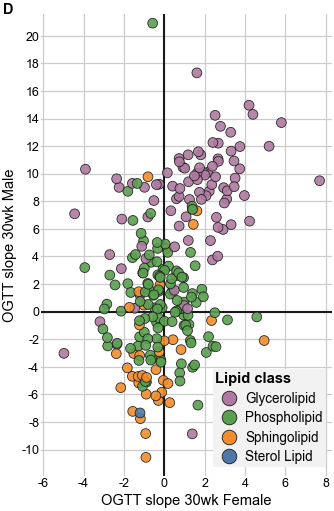

In [908]:
def slope_vs_slope_wrapper(ax=None):
    if ax is None:
        fig, ax = plt.subplots(dpi=150, figsize=(2.5, 4))
    importlib.reload(src.plots)
    vldata['size_dummy'] = 0
    df = vldata.copy()
    outliers = {
#         'vl_6200': dict(x=-10, y=0),  # TG 55:3
#         'vl_6379': dict(x=10, y=3),  # TG 60:4
#         'vl_5645': dict(x=8, y=0),    # TG 50:3
#         'vl_6431': dict(x=10, y=-7),  # TG 18:2 18:1 23:0
#         'vl_6458': dict(x=14, y=6),   # TG 18:2 18:1 24:0
#         'vl_6461': dict(x=1, y=-9),  # TG 58:2
#         'vl_6436': dict(x=-2, y=9),  # TG 57:2
#         'vl_6183': dict(x=-2, y=8),  # TG 53:2
#         'vl_5748': dict(x=2, y=8),  # TG 57:7

#         'vl_2305':  dict(x=-2, y=9),  # PC 33:3
#         'vl_5226': dict(x=0, y=-10),  # TG 16:0 20:5 22:6  58:11
#         'vl_5124': dict(x=0, y=-10),  # TG 18:2 20:5 22:5
#         'vl_2813': dict(x=-4, y=-10),  # PC 41:6
#         'vl_3013': dict(x=10, y=2),  # Cer[NP] t18:0 16:0
#         'vl_4879': dict(x=-2, y=-9),  # TG 22:6 66:18
#         'vl_5174': dict(x=7, y=0),  #  TG 52:7

#         'vl_4920': dict(x=-8, y=-4),  # TG 18:2 20:5 20:5  58:12
#         'vl_2876': dict(x=0, y=-10),  # SM d34:0
#         'vl_4004': dict(x=0, y=-18),  # SM d41:2
#         'vl_4133': dict(x=-3, y=-15),  # SM d42:2
#         'vl_5883': dict(x=0, y=-10), # CE 18:2
#         'vl_5024': dict(x=0, y=-10),  # TG 60:13
#     #     'vl_5224': dict(x=-2, y=-10),  # TG 60:12
#         'vl_2167': dict(x=-5, y=-6),  #
#         'vl_5156': dict(x=3, y=-7),  #  TG 


#         'vl_2384': dict(x=0, y=10), # SM d42:7
#         'vl_3484': dict(x=6, y=7),  # PC 40:5
#         'vl_6022': dict(x=0, y=10),  # TG 16:0 18:0 20:4
#         'vl_4657': dict(x=-2, y=25),  # Cer
        }
    df['outlier'] = df.index.isin(outliers)
    src.plots.slope_vs_slope(
        df=df, x='coef_female_ogtt', y='coef_male_ogtt', metab_type='lipid', ax=ax,
        size='outlier', alpha=0.9, aspect_equal=False, show_legend=False, )
#     ax.set_aspect('equal')
    ax.set_ylim(-11.9e-5, 21.6e-5)
    ax.set_xlim(-6.1e-5, 8.3e-5)
    ax.set_ylabel('OGTT slope 30wk Male')
    ax.set_xlabel('OGTT slope 30wk Female')
    for i, row in df.loc[outliers].iterrows():
        xy = (row['coef_male_ogtt'], row['coef_female_ogtt'])
        if 't' in outliers[i]:
            text = outliers[i]['t']
        else:
            text = row['ID']
        parse = src.utils.parse_lipid(text)
        text = f'{parse[0]} {parse[4]}'
        src.plots.annotate_point(
            text=text, xy=xy, xytext=(outliers[i]['x'], outliers[i]['y']), ax=ax, zorder=7)
    legend = src.plots.custom_legend(
        vldata['superclass'].unique()[1:], ax, loc=(0.59, 0.02),
        title='Lipid class', show_frame=True, fontsize=6.5, ms=7,
    )
    bb = src.plots.tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1, s='D', 
            fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)
    return ax
ax = slope_vs_slope_wrapper()
plt.savefig('../reports/figures/Figure7/Fig7D_slope_vs_slope_vertical_orientation.pdf', 
            bbox_inches='tight', dpi=300)

In [112]:
pdf = vldata.loc[vldata['is_id']].copy()
pdf['i'] = pdf.index

px_colors = {'Phospholipid': 'green', 'Sphingolipid': 'orange', 
             'Glycerolipid': 'purple', 'Sterol Lipid': 'blue'}

px.scatter(
    pdf, x='coef_male_ogtt', y='coef_female_ogtt', 
    color='superclass', color_discrete_map=px_colors,
#     color_discrete_map=colors,
    hover_data=['ID', 'i', 'molec_class'], )

# Correlation of each lipid to OGTT in 10wk, 30wk male, 30wk female

## First, align IDs between datasets

In [689]:
ddf = data.loc[(data['ID'] != 'Unidentified') & (data['Type'] == 'lipid')].copy()
vdf = vldata.loc[vldata['is_id']].copy()

ddf['name'] = ddf['molec_class'] + ' ' + ddf['fa_carbon:unsat']
vdf['name'] = vdf['molec_class'] + ' ' + vdf['fa_carbon:unsat']

align_d = {}
for d_i, dname in ddf['name'].iteritems():
    align_d[d_i] = []
    for v_i, vname in vdf['name'].iteritems():
        if dname == vname:
            align_d[d_i].append(v_i)
            
matches = [(x, align_d[x][0]) for x in align_d if len(align_d[x]) == 1]
matches = pd.DataFrame(matches, columns=['original', 'val']).merge(
    data[['ID', 'molec_class', 'superclass']], left_on='original', right_index=True)
matches

,original,val,ID,molec_class,superclass
0,l_53,vl_948,LysoPC 17:0,LysoPC,Phospholipid
1,l_55,vl_946,LysoPC 20:2,LysoPC,Phospholipid
2,l_56,vl_948,LysoPC 17:0,LysoPC,Phospholipid
3,l_62,vl_1056,LysoPC 18:0,LysoPC,Phospholipid
4,l_65,vl_1056,LysoPC 18:0,LysoPC,Phospholipid
...,...,...,...,...,...
154,l_900,vl_6431,TG 18:2_18:1_23:0,TG,Glycerolipid
155,l_905,vl_6436,TG 57:2,TG,Glycerolipid
156,l_907,vl_6454,TG 56:1,TG,Glycerolipid
157,l_908,vl_6458,TG 18:2_18:1_24:0,TG,Glycerolipid


## Next calculate correlation values in each dataset

In [780]:
mogtt = fg.loc[fg['validation'] & (fg['sex'] == 'M') & (fg['cohort'] == '30wk'), 'ogtt']
fogtt = fg.loc[fg['validation'] & (fg['sex'] == 'F') & (fg['cohort'] == '30wk'), 'ogtt']

o_ogtt_corr = ddf.loc[matches['original'], data_cols].T.corrwith(fg['ogtt'])
v_male_ogtt_corr = vdf.loc[matches['val'], mogtt.index].T.corrwith(fg['ogtt'])
v_female_ogtt_corr = vdf.loc[matches['val'], fogtt.index].T.corrwith(fg['ogtt'])
o_ogtt_corr.name = 'orig_corr'
v_male_ogtt_corr.name = 'val_male_corr'
v_female_ogtt_corr.name = 'val_female_corr'

matches = matches.merge(o_ogtt_corr, left_on='original', right_index=True)
matches = matches.merge(v_male_ogtt_corr, left_on='val', right_index=True)
matches = matches.merge(v_female_ogtt_corr, left_on='val', right_index=True)

# for some reason, things are getting duplicated, so filter:
# THIS FILTER CURRENTLY 
vc = matches['original'].value_counts()
unique = vc.loc[vc == 1].index
matches = matches.loc[matches['original'].isin(unique)]
matches['IDshort'] = (matches['ID']
                      .str.replace('Plasmanyl-', 'Plma')
                      .str.replace('Plasmenyl-', 'Plme'))
matches

,original,val,ID,molec_class,superclass,orig_corr_x,val_male_corr_x,val_female_corr_x,IDshort,orig_corr_y,val_male_corr_y,val_female_corr_y,orig_corr,val_male_corr,val_female_corr
1,l_55,vl_946,LysoPC 20:2,LysoPC,Phospholipid,-0.162889,0.458040,0.042556,LysoPC 20:2,-0.162889,0.458040,0.042556,-0.162889,0.458040,0.042556
6,l_160,vl_2079,PI 16:0_20:4,PI,Phospholipid,0.081000,0.217326,-0.153737,PI 16:0_20:4,0.081000,0.217326,-0.153737,0.081000,0.217326,-0.153737
7,l_163,vl_2119,SM d32:1,SM,Sphingolipid,-0.093680,-0.598073,-0.212146,SM d32:1,-0.093680,-0.598073,-0.212146,-0.093680,-0.598073,-0.212146
9,l_166,vl_2148,SM d40:7,SM,Sphingolipid,0.548761,0.179262,-0.187337,SM d40:7,0.548761,0.179262,-0.187337,0.548761,0.179262,-0.187337
10,l_168,vl_2146,PI 16:0_18:2,PI,Phospholipid,0.032928,0.249366,-0.361441,PI 16:0_18:2,0.032928,0.249366,-0.361441,0.032928,0.249366,-0.361441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,l_900,vl_6431,TG 18:2_18:1_23:0,TG,Glycerolipid,0.248565,0.466119,0.202118,TG 18:2_18:1_23:0,0.248565,0.466119,0.202118,0.248565,0.466119,0.202118
155,l_905,vl_6436,TG 57:2,TG,Glycerolipid,0.251067,0.403086,0.238219,TG 57:2,0.251067,0.403086,0.238219,0.251067,0.403086,0.238219
156,l_907,vl_6454,TG 56:1,TG,Glycerolipid,0.238909,0.407029,0.215433,TG 56:1,0.238909,0.407029,0.215433,0.238909,0.407029,0.215433
157,l_908,vl_6458,TG 18:2_18:1_24:0,TG,Glycerolipid,0.259595,0.490208,0.221208,TG 18:2_18:1_24:0,0.259595,0.490208,0.221208,0.259595,0.490208,0.221208


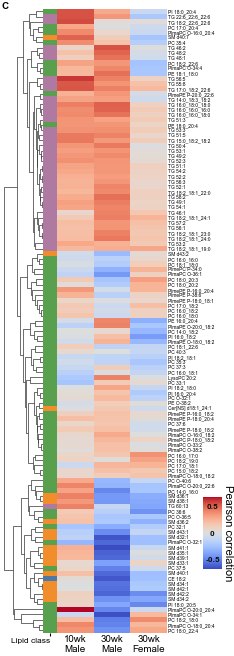

In [907]:
cm = sns.clustermap(
    data=matches[['orig_corr', 'val_male_corr', 'val_female_corr']], 
    col_cluster=False, 
#     row_cluster=False,
    figsize=(2.8, 7.2), row_colors=matches['superclass'].map(colors),
    cmap='coolwarm', #vmin=-0.6, vmax=0.6,
    cbar_pos=(0.77, 0.2, 0.07, 0.1), dendrogram_ratio=[0.25, 0], colors_ratio=[0.08, 0],
    yticklabels=matches['IDshort'],
)
fig = cm.fig
fig.set_dpi(100)
hm = cm.ax_heatmap
hm.tick_params(axis='y', labelsize=3.5, length=0, pad=0.5)
hm.set_xticks([0.5, 1.5, 2.5], ['10wk\nMale', '30wk\nMale', '30wk\nFemale'])
hm.tick_params(axis='x', labelsize=7, length=0, pad=1.5, rotation=0)
cm.ax_row_colors.set_xticks([0.5], ['Lipid class'], rotation=0, ha='right')
cm.ax_cbar.set_ylabel('Pearson correlation', rotation=270, va='center')
cm.ax_cbar.set_yticks([])
# cm.ax_cbar.tick_params(length=0, pad=-5)
for tick in [-0.5, 0, 0.5]:
    cm.ax_cbar.text(0.5, tick, tick, color='0.05', fontsize=6, fontweight='bold', ha='center')
# cm.ax_cbar.set_yticks([-0.5, 0, 0.5], [-0.5, 0, 0.5], color='white', zorder=10)
# cm.ax_cbar.set_zorder(0)
bb = src.plots.tight_bbox(cm.ax_row_dendrogram)
cm.ax_row_dendrogram.text(x=bb.x0, y=bb.y1, s='C', 
        fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)
plt.savefig('../reports/figures/Figure7/Fig7C_ogtt_corr_heatmap.pdf', bbox_inches='tight', dpi=300)

# Do quadrants enrich for certain levels of unsaturation? 

In [513]:
edf = vldata.loc[vldata['is_id']].copy()
# Drop slopes that are near zero

def get_quadrant(x, y):
    if x > 0 and y > 0: return 'q1'
    if x < 0 and y > 0: return 'q2'
    if x < 0 and y < 0: return 'q3'
    if x > 0 and y < 0: return 'q4'

# edf = edf.loc[(edf['coef_male_ogtt'].abs() > 1e-5) & 
#               (edf['coef_female_ogtt'].abs() > 1e-5)]
# edf['q1'] = (edf['coef_male_ogtt'] > 0) & (edf['coef_female_ogtt'] > 0)
# edf['q2'] = (edf['coef_male_ogtt'] < 0) & (edf['coef_female_ogtt'] > 0)
# edf['q3'] = (edf['coef_male_ogtt'] < 0) & (edf['coef_female_ogtt'] < 0)
# edf['q4'] = (edf['coef_male_ogtt'] > 0) & (edf['coef_female_ogtt'] < 0)
edf['quadrant'] = (edf[['coef_male_ogtt', 'coef_female_ogtt']]
                   .apply(lambda x: get_quadrant(x[0], x[1]), axis=1)
                  )
edf['unsat_ratio'] = (edf['fa_unsat'] / edf['fa_carbons'])

<AxesSubplot:xlabel='unsat_ratio', ylabel='Density'>

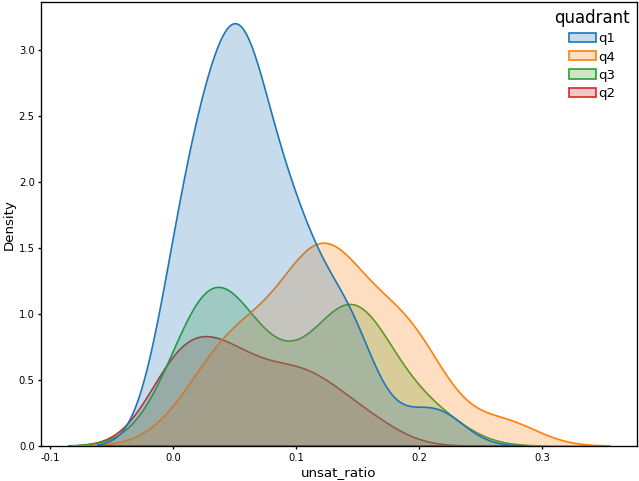

In [514]:
# fig, ax = plt.subplots(dpi=150, figsize=(4, 3))
sns.kdeplot(
    data=edf, x='unsat_ratio', hue='quadrant', fill=True,# kind='kde',

)
# sns.histplot(data=edf, x='')

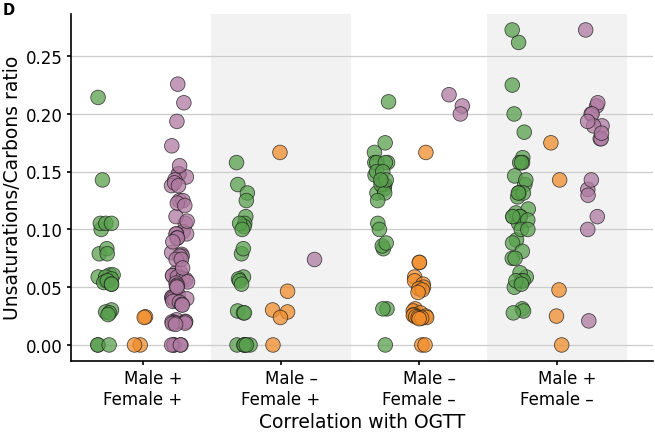

In [553]:
order = ['q1', 'q2', 'q3', 'q4']
order_label = ['    Male +\nFemale +', '    Male –\nFemale +', 
               '    Male –\nFemale –', '    Male +\nFemale –']
fig, ax = plt.subplots(dpi=150, figsize=(5,3.))
sns.stripplot(
    data=edf.loc[edf['superclass'] != 'Sterol Lipid'], x='quadrant', y='unsat_ratio', 
    hue='superclass', palette=colors,
    order=order,
    jitter=0.18, size=7, alpha=0.75,
    linewidth=src.plots.POINT_LW, edgecolor=src.plots.POINT_EC,
#     size=3.5,
    dodge=True,
    zorder=2,
)
# sns.violinplot(
#     data=edf.loc[edf['superclass'] != 'Sterol Lipid'], x='quadrant', y='unsat_ratio', 
# #     hue='superclass', palette=colors, dodge=True,
#     ax=ax, zorder=0,
# #     split=True,
# )
ax.axvspan(0.5, 1.5, zorder=0, color='0.95')
ax.axvspan(2.5, 3.5, zorder=0, color='0.95')
ax.set_xticks([0, 1, 2, 3], order_label, fontsize=8, ha='center', )
ax.tick_params(axis='y', labelsize=8)

# ax.set_ylabel(None)
ax.set_xlabel('Correlation with OGTT', fontsize=9)
# ax.set_title('Unsaturations/Carbons ratio', loc='left', va='top')
ax.set_ylabel('Unsaturations/Carbons ratio', fontsize=9)
ax.grid(axis='y', lw=src.plots.GRID_LW, color=src.plots.GRID_LIGHT_COLOR)
ax.set_axisbelow(True)
# ax.legend(loc=(1.01, 0), title='Lipid class')
ax.legend().remove()
offset = 0.266
# src.plots.annotate_point(xy=(3 + offset, 18/66), text='TG 66:18', xytext=(0, -7),
#                          ax=ax, zorder=1, fontsize=8, bbox_pad=2)

sns.despine()
bb = src.plots.tight_bbox(ax)
ax.text(x=bb.x0, y=bb.y1, s='D', 
        fontsize=src.plots.LABEL_FONTSIZE, fontweight='bold', transform=fig.transFigure)

plt.savefig('../reports/figures/Figure7/Fig7_quadrant_enrichment.pdf', bbox_inches='tight', dpi=300)

# Perform ANOVA to see if the 4 quadrants have significantly different unsat/carbon ratio 

In [554]:
ldf = edf.loc[(edf['molec_class'] == 'TG') & (edf['quadrant']!='q2')]  # TG
# ldf = edf.loc[(edf['superclass'] == 'Phospholipid')]           # Phospholipids
# ldf = edf.loc[(edf['superclass'] == 'Sphingolipid') & (edf['quadrant'] != 'q1')]  # Sphingos
statsmodels.stats.multicomp.MultiComparison(
    data=ldf['unsat_ratio'], groups=ldf['quadrant'],
).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
q1,q3,0.1328,0.0002,0.0577,0.208,True
q1,q4,0.0921,0.0,0.0576,0.1267,True
q3,q4,-0.0407,0.4462,-0.1204,0.039,False


## Mixed effects formulation 

In [467]:
mdf = edf[['unsat_ratio', 'quadrant', 'superclass']]
mdf = mdf.loc[mdf['superclass'] != 'Sterol Lipid']
mlm = sm.formula.mixedlm(
    'unsat_ratio ~ quadrant', data=mdf, groups='superclass',
).fit(reml=True)
mlm.summary()

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.



<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: unsat_ratio
No. Observations: 124     Method:             REML       
No. Groups:       3       Scale:              0.0030     
Min. group size:  15      Log-Likelihood:     170.2537   
Max. group size:  68      Converged:          Yes        
Mean group size:  41.3                                   
---------------------------------------------------------
                 Coef. Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept        0.040    0.024 1.630 0.103 -0.008  0.088
quadrant[T.q2]   0.031    0.020 1.543 0.123 -0.008  0.069
quadrant[T.q3]   0.080    0.018 4.385 0.000  0.044  0.115
quadrant[T.q4]   0.092    0.014 6.547 0.000  0.065  0.120
superclass Var   0.001    0.031                          
=========================================================

"""

In [564]:
data.loc['l_679', data_cols].to_frame().corrwith(fg['ogtt'].to_frame())

ogtt   NaN
dtype: float64

In [565]:
from scipy.stats import pearsonr

In [579]:
pearsonr(data.loc['l_679', data_cols], fg.loc[fg['original'], 'ogtt'].drop('1091_9_FBG'))

(0.473696485111207, 0.00015096854467108132)

<AxesSubplot:>

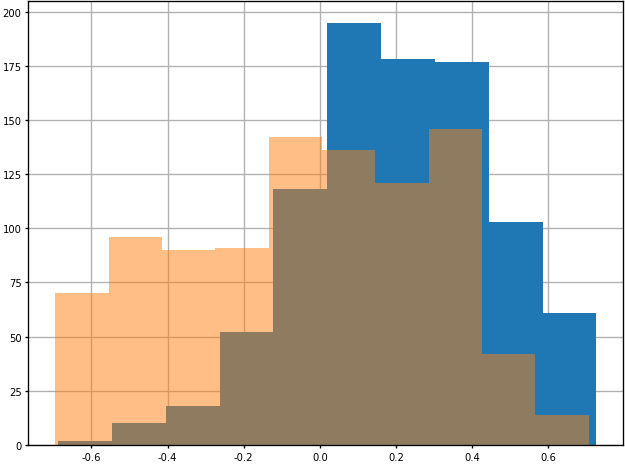

In [594]:
corrs = data.loc[data['Type']=='lipid', data_cols].T.corrwith(
    fg.loc[fg['original'], 'ogtt'].drop('1091_9_FBG')
)
corrs.hist()
val_corrs = vldata.loc[:, vldata_cols].T.corrwith(
    fg.loc[fg['validation'] & fg['quant_file'], 'ogtt']
)
val_corrs.hist(alpha=0.5)

In [598]:

fogtt

1731_30_RBG    41218.5
1731_31_RBG    41218.5
1731_32_RBG    41218.5
1742_32_RBG    25742.5
1742_33_RBG    25742.5
1742_34_RBG    25742.5
1743_31_RBG    35757.5
1743_32_RBG    35757.5
1743_33_RBG    35757.5
1746_30_RBG    29785.0
1746_31_RBG    29785.0
1746_32_RBG    29785.0
1748_29_RBG    37650.0
1748_30_RBG    37650.0
1748_31_RBG    37650.0
1754_30_RBG    31460.0
1754_31_RBG    31460.0
1754_32_RBG    31460.0
Name: ogtt, dtype: float64

<AxesSubplot:>

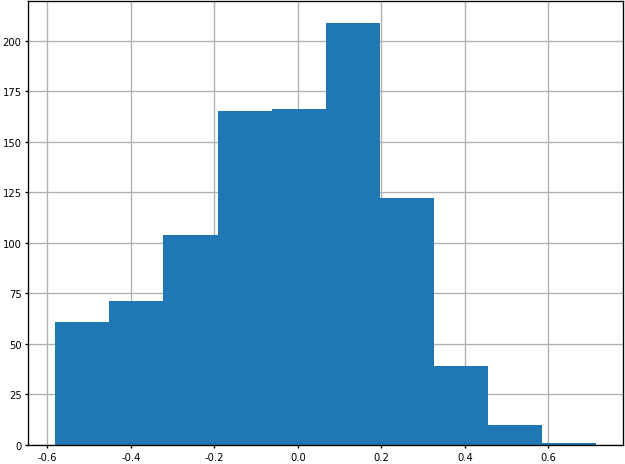

In [605]:
# vldata.loc[:, mogtt.index].T.corrwith(mogtt).hist()
vldata.loc[:, fogtt.index].T.corrwith(fogtt).hist()